
## Test differences between binned interpolated Eulerian mean field $<\bar u_i>$ and binned "real" Eulerien field, $<\bar u_E>$

Test to run : 

1) Size of bins
2) Number of floats used in bins

In [2]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5359764.datarmor0/parcels-502090/libparcels_random_9ade00de-85ea-48c4-bd5e-d6cd3b7bd00d.so


In [1]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=3)
#
client = Client(cluster)




In [4]:
client

Client Scheduler: tcp://10.148.0.36:55700 Dashboard: http://10.148.0.36:8787/status,Cluster Workers: 21 Cores: 21 Memory: 335.37 GiB


In [3]:
def read_Ediag(V,diags):
    ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in diags])

    grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
    ds = xr.merge([ds,grid])
    #ds = ds#.isel(i = slice(0,None,4), j = slice(0,None,4), i_g = slice(0,None,4), j_g = slice(0,None,4))
    ds['lon'] = 0*ds.face+ds.XC
    ds['lat'] = 0*ds.face+ds.YC
    ds = ds.compute()
    # Rotation velocity field
    for diag in diags:
        ds['zonal_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.CS - ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.SN
        ds['meridional_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.SN + ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.CS

        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
 #   ds = llcreader.faces_dataset_to_latlon(ds)
    return ds

In [5]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 

df = df.persist()

In [27]:
# Eulerian data
V = ["SSU","SSV"]#["SSU", "SSV"]
D = ["mean"]#, "prime_mean","prime_mean_sq"]
ds = read_Ediag(V,D)

In [20]:
def binned_spectra_site(bbox,df,dl,V):
    df_sub = df[np.logical_and(df.lat<bbox[3],df.lat>bbox[2]
                                               )].persist()

    df_sub = df[np.logical_and(df.lon<bbox[1],df.lon>bbox[0]
                                          )].persist()
    lon = np.arange(bbox[0],bbox[1], dl)
    lat = np.arange(bbox[-2], bbox[-1], dl)
    df_sub['lon'] = (df_sub['lon']+180)%360 - 180
    df_sub['lon_cut'] = df_sub['lon'].map_partitions(pd.cut, lon)
    df_sub['lat_cut'] = df_sub['lat'].map_partitions(pd.cut, lat)
    df_sub = df_sub.persist()
    uv_sub = df_sub.groupby(['lon_cut','lat_cut']).mean().compute()
    return uv_sub

In [35]:
def binned_Espectra_site(bbox,ds,dl,V):
    ds_sub = ds[V].where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()
    ds_sub = ds_sub.where(np.logical_and(ds_sub.lon<=bbox[1],ds_sub.lat>=bbox[0]),drop=True).persist()
#    lat = np.arange(bbox[-2], bbox[-1], dl)
#    lon = np.arange(bbox[0],bbox[1], dl)
#    N = histogram(ds_sub.lat, bins=[lon,lat], 
#              dim=['i', 'j', 'face']
#            ).persist()
#   E = histogram(ds_sub.lat4.rename('lat'), bins=[lat], 
#              weights=ds_sub.SSUV, 
#              dim=['i', 'j', 'face']
#             )

#    E = (E/N).rename('E_SSUV').persist()
#    E = E.rename({'freq_time': 'frequency','lat_bin':'lat_bins'})
    return ds_sub

In [8]:
bbox = [-128, -123, 33, 38] # small bbox

In [9]:
dl = 1.

In [11]:
df = df.drop(columns=['temperature','salinity','sea_level','Eta_interp','SST_interp','SSS_interp'])

In [21]:
test = binned_spectra_site(bbox,df,dl,'SSU_interp')

In [23]:
test = pa.add_geodata(test)

In [25]:
test = (test
 #     .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

In [26]:
test

<xarray.Dataset>
Dimensions:              (lat: 4, lon: 4)
Coordinates:
  * lon                  (lon) float64 -127.5 -126.5 -125.5 -124.5
  * lat                  (lat) float64 33.5 34.5 35.5 36.5
Data variables:
    trajectory           (lon, lat) float64 3.73e+07 3.746e+07 ... 3.729e+07
    z                    (lon, lat) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    zonal_velocity       (lon, lat) float64 -0.0353 -0.01968 ... 0.08333
    meridional_velocity  (lon, lat) float64 -0.0866 -0.1057 ... -0.09055 -0.1
    SSU_interp           (lon, lat) float64 -0.0252 -0.02217 ... 0.06306
    SSV_interp           (lon, lat) float64 -0.08629 -0.09746 ... -0.1013

In [29]:
ds

<xarray.Dataset>
Dimensions:                   (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320)
Coordinates: (12/20)
  * face                      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g                       (i_g) int64 0 1 2 3 4 ... 4315 4316 4317 4318 4319
  * j                         (j) int64 0 1 2 3 4 5 ... 4315 4316 4317 4318 4319
  * i                         (i) int64 0 1 2 3 4 5 ... 4315 4316 4317 4318 4319
  * j_g                       (j_g) int64 0 1 2 3 4 ... 4315 4316 4317 4318 4319
    CS                        (face, j, i) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                        ...
    dyC                       (face, j_g, i) float32 239.5 239.5 ... 324.6 324.6
    dyG                       (face, j, i_g) float32 479.0 479.0 ... 324.6 324.6
    rA                        (face, j, i) float32 1.555e+05 ... 1.555e+05
    rAs                       (face, j_g, i) float32 7.774e+04 ... 1.555e+05
    rAw                       (face, j, i_g) float32 1.555e+05 ... 1.555e+05
    rAz                       (face, j_g, i_g) float32 7.774e+04 ... 1.555e+05
Data variables:
    mean_SSU                  (face, j, i_g) float32 nan nan nan ... nan nan nan
    mean_SSV                  (face, j_g, i) float32 nan nan nan ... nan nan nan
    lon                       (face, j, i) float64 -114.9 -114.9 ... -114.9
    lat                       (face, j, i) float64 -88.18 -88.18 ... -88.17
    zonal_velocity_mean       (face, j, i) float32 nan nan nan ... nan nan nan
    meridional_velocity_mean  (face, j, i) float32 nan nan nan ... nan nan nan

In [45]:
ds_sub = ds['zonal_velocity_mean'].where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()

In [46]:
ds_lon = ds['lon'].where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()

In [47]:
ds_lat = ds['lat'].where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()

In [48]:
ds_bis = xr.Dataset({'lon':ds_lon,'zonal_velocity_mean':ds_sub,'lat':ds_lat})

In [49]:
ds_sub = ds_bis.where(np.logical_and(ds_bis.lon<=bbox[1],ds_bis.lon>=bbox[0]),drop=True).persist()

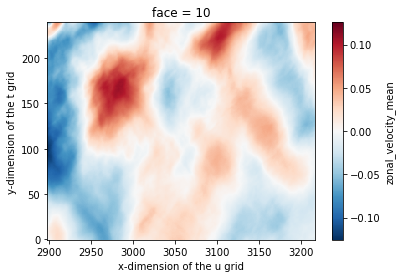

In [55]:
ds_sub.isel(face=0)['zonal_velocity_mean'].plot()

In [62]:
lon_E = ds_sub.lon[0,:,0]
lat_E = ds_sub.lat[0,0,:]

In [70]:
lat_E.values

array([37.99409866, 37.97891998, 37.96373749, 37.94855499, 37.93336868,
       37.91817856, 37.90298462, 37.88779068, 37.87259293, 37.85739136,
       37.84218597, 37.82697678, 37.81176758, 37.79655457, 37.78133774,
       37.7661171 , 37.75089645, 37.735672  , 37.72044373, 37.70521164,
       37.68997955, 37.67474365, 37.65950394, 37.64426041, 37.62901306,
       37.61376572, 37.59851456, 37.58325958, 37.56800461, 37.552742  ,
       37.5374794 , 37.52221298, 37.50694656, 37.49167252, 37.47639847,
       37.46112061, 37.44583893, 37.43055725, 37.41527176, 37.39998245,
       37.38468933, 37.3693924 , 37.35409546, 37.33879471, 37.32349014,
       37.30818558, 37.29287338, 37.27756119, 37.26224518, 37.24692535,
       37.23160553, 37.21628189, 37.20095444, 37.18562317, 37.1702919 ,
       37.154953  , 37.13961411, 37.12427521, 37.10892868, 37.09358215,
       37.07823181, 37.06287766, 37.04751968, 37.03216171, 37.01679993,
       37.00143433, 36.98606491, 36.9706955 , 36.95531845, 36.93

In [73]:
ds_E = xr.DataArray(ds_sub.isel(face=0)['zonal_velocity_mean'].values,dims=['lon','lat'],coords={'lon':lon_E.values,'lat':lat_E.values})

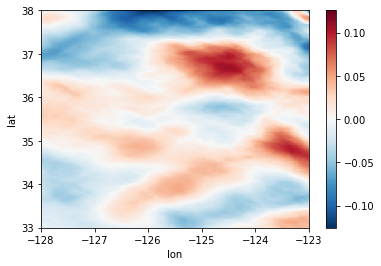

In [74]:
ds_E.plot(y='lat')

In [79]:
lon = np.arange(bbox[0],bbox[1], dl)
lat = np.arange(bbox[-2], bbox[-1], dl)

In [80]:
df_E = ds_E.to_dataframe(name='mean_SSU').reset_index()

In [84]:
pd.cut(df_E['lon'],bins=lon)

0        (-128.0, -127.0]
1        (-128.0, -127.0]
2        (-128.0, -127.0]
3        (-128.0, -127.0]
4        (-128.0, -127.0]
               ...       
76795                 NaN
76796                 NaN
76797                 NaN
76798                 NaN
76799                 NaN
Name: lon, Length: 76800, dtype: category
Categories (4, interval[float64]): [(-128.0, -127.0] < (-127.0, -126.0] < (-126.0, -125.0] < (-125.0, -124.0]]

In [85]:
df_E['lon_cut'] = pd.cut(df_E['lon'],bins=lon)
df_E['lat_cut'] = pd.cut(df_E['lat'],bins=lat)

In [87]:
df_Emean = df_E.groupby(['lon_cut','lat_cut']).mean()

In [88]:
df_Emean = (df_Emean
 #     .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

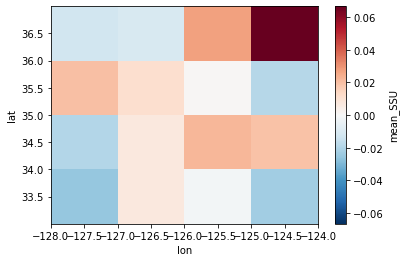

In [92]:
df_Emean.mean_SSU.plot(y='lat')

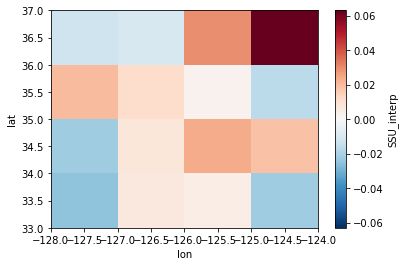

In [76]:
test.SSU_interp.plot(y='lat')

In [100]:
print(test.SSU_interp/df_Emean.mean_SSU)
#print(df_Emean.mean_SSU)

<xarray.DataArray (lon: 4, lat: 0)>
array([], shape=(4, 0), dtype=float64)
Coordinates:
  * lat      (lat) float64 
  * lon      (lon) float64 -127.5 -126.5 -125.5 -124.5


In [101]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
